### Analyze quantum stocks

In [1]:
# %pip install statsmodels

Recently, some quantum stocks raise 50% or up in a week (date of today is 2025-10-6).
This articles look at the correlation of the stocks and find out if they have any lead/lag relation.

#### Prepare data
Analysis is based on these stocks IBIT, MCD, AAPL, IONQ, QBTS, QUBT, RGTI. They cover cryptocurrency, McDonald, Apple and 4 quantum stocks.

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from ta.trend import MACD
from ta.momentum import StochasticOscillator
from html2image import Html2Image
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import grangercausalitytests
from IPython.display import HTML, Image
import os

In [3]:
TRADE_DAYS_PER_YEAR = 251
LEFT_MIN = 21       # trade days per month
LEFT_AVERAGE = 21
LEFT_MAX = 5        # arbitrary take
RIGHT_MAX = 5       # arbitrary take

PLOT_WIDTH = 800
PLOT_HEIGHT = 600

In [4]:
QUANTUMS = ['IONQ', 'QBTS', 'QUBT', 'RGTI']
NON_QUANTUMS = ['IBIT', 'MCD', 'AAPL']
SYMBOLS = NON_QUANTUMS + QUANTUMS

In [5]:
def calculate_rsi_sma(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def smma(series, period):
    smma = series.copy()
    smma.iloc[:period] = series.iloc[:period].mean()  # seed with SMA
    for i in range(period, len(series)):
        smma.iloc[i] = ((smma.iloc[i - 1] * (period - 1)) + series.iloc[i]) / period
    return smma

def calculate_rsi_smma(data, period=14):
    delta = data.diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = smma(gain, period)
    avg_loss = smma(loss, period)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_rsi_ema(data, period=14):
    # Calculate price change
    delta = data.diff()

    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Apply Exponential Moving Average
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def prepare_df(ticker, days=0, start_date='2024-09-01', end_date='2025-08-31', average_method='sma'):
    '''
    average_method: 
        'sma' for Simple Moving Average
        'smma' for Smoothing Moving Average
        'ema' for Exponential Moving Average
    '''
    if days > 0:
        df = yf.download(ticker, period=f'{days}d', auto_adjust=True, progress=False)
    else:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
    
    # keep only the "Open", "Close" etc for plotly. also remove the unnecessary [] of df['Close'].values
    df.columns = df.columns.droplevel(1)    

    if average_method == 'sma':
        df['RSI'] = calculate_rsi_sma(df['Close'])
    elif average_method == 'smma':
        df['RSI'] = calculate_rsi_smma(df['Close'])
    elif average_method == 'ema':
        df['RSI'] = calculate_rsi_ema(df['Close'])
    else:
        df['RSI'] = calculate_rsi_sma(df['Close'])

    # add moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA5'] = df['Close'].rolling(window=5).mean()

    # MACD
    macd = MACD(close=df['Close'],
                      window_slow=26,
                      window_fast=12,
                      window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()

    # stochastic
    stoch = StochasticOscillator(high=df['High'],
                                       close=df['Close'],
                                       low=df['Low'],
                                       window=14,
                                       smooth_window=3)
    df['Stoch'] = stoch.stoch()
    df['Stoch_Signal'] = stoch.stoch_signal()

    df['Volume_log'] = np.log1p(df['Volume'])
    mean_volume_log = df['Volume_log'].mean()
    std_volume_log = df['Volume_log'].std()
    df['Volume_log_Norm'] = (df['Volume_log'] - mean_volume_log) / std_volume_log

    # close raise flag, up is +1, down is -1
    df['Close_Raise'] = df['Close'].diff().apply(lambda x: 1 if x >= 0 else -1)
    
    return df, mean_volume_log, std_volume_log

In [6]:
def plot_price_rsi(df, title='Price, RSI'):
    fig, ax1 = plt.subplots()
    plt.title(title)
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    x_interval = int(len(df) / 21 / 10)
    if x_interval == 0:
        x_interval = 1
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    ax1.set_ylabel('Close Price', color='blue')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['RSI'], label='RSI', color='g')
    ax2.set_ylabel('RSI', color='g')
    ax2.axhline(y=70, color='g', linestyle='-', label='RSI 70')
    ax2.axhline(y=30, color='g', linestyle='-', label='RSI 30')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='lower right')
    plt.show()

In [7]:
dfs = {}
mean_volume_logs = {}
std_volume_logs = {}
for symbol in SYMBOLS:
    dfs[symbol], mean_volume_logs[symbol], std_volume_logs[symbol] = prepare_df(symbol, start_date='2022-09-01', end_date='2025-10-04', average_method='ema')  # 3 years data

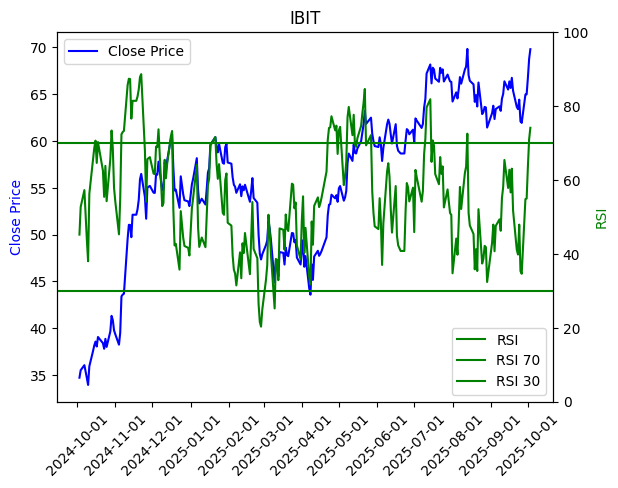

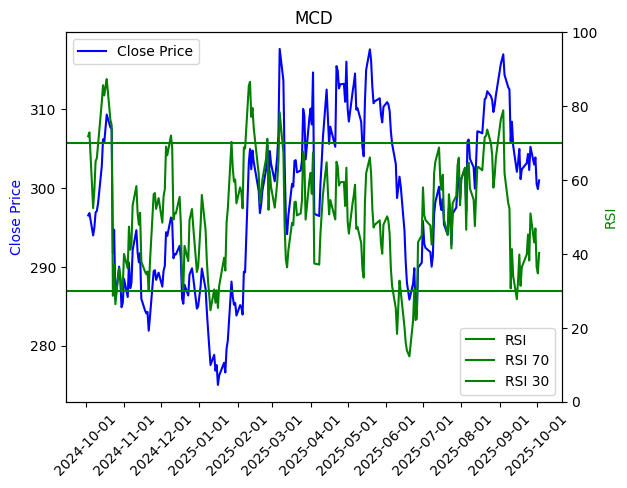

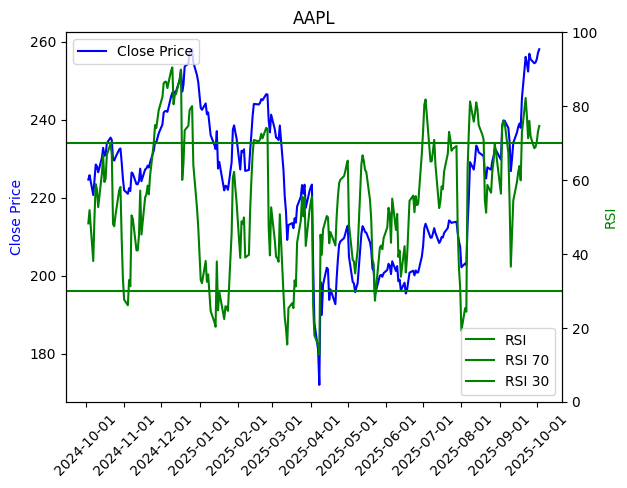

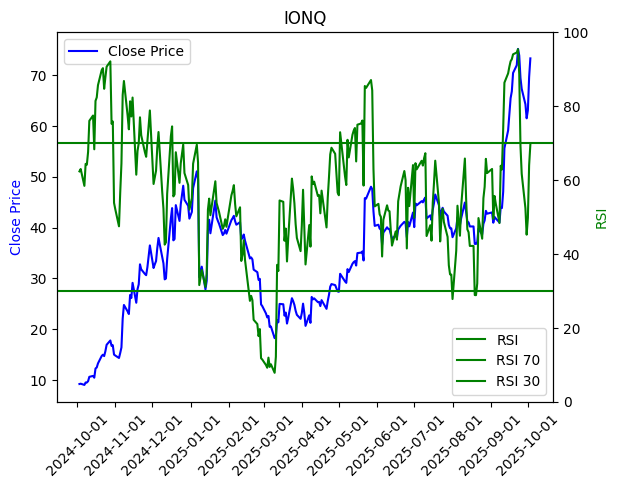

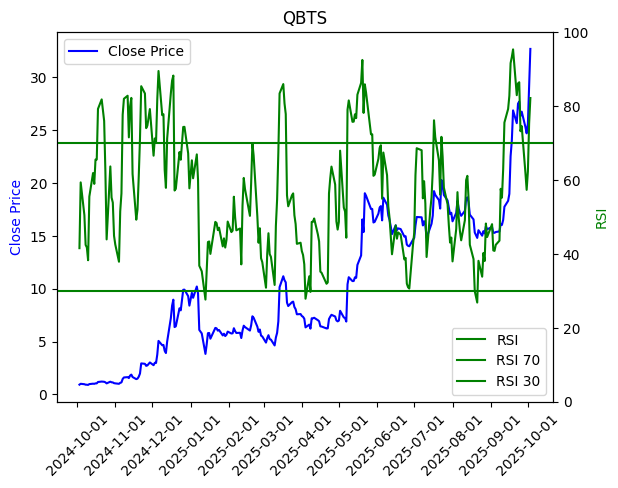

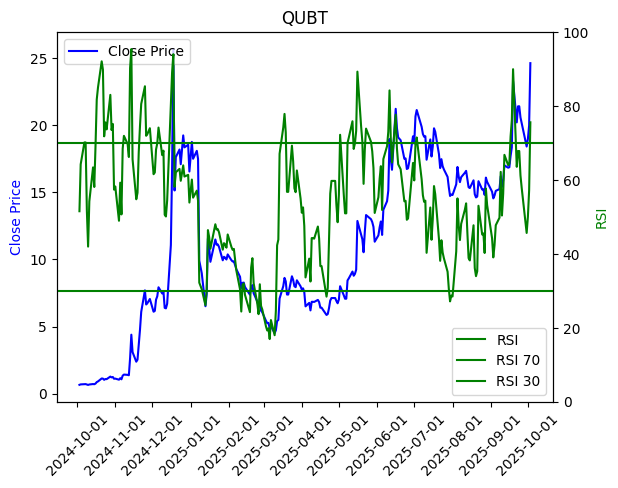

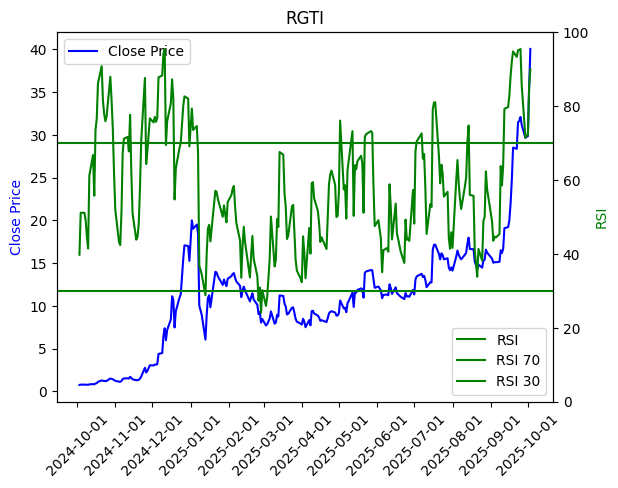

In [8]:
for symbol in SYMBOLS:
    plot_price_rsi(dfs[symbol][-TRADE_DAYS_PER_YEAR:], title=symbol)


In [9]:
stock_closes = pd.concat([
    dfs[s]['Close'].rename(s) for s in SYMBOLS
], axis=1)

Last year correlation.

In [10]:
corr_matrix = stock_closes[-TRADE_DAYS_PER_YEAR:].corr()
print(corr_matrix)

          IBIT       MCD      AAPL      IONQ      QBTS      QUBT      RGTI
IBIT  1.000000  0.116946  0.002782  0.841722  0.807112  0.838628  0.740056
MCD   0.116946  1.000000 -0.242977 -0.006507  0.334477  0.027277  0.205899
AAPL  0.002782 -0.242977  1.000000  0.260612 -0.077520  0.047947  0.203232
IONQ  0.841722 -0.006507  0.260612  1.000000  0.820474  0.860832  0.890852
QBTS  0.807112  0.334477 -0.077520  0.820474  1.000000  0.858027  0.878058
QUBT  0.838628  0.027277  0.047947  0.860832  0.858027  1.000000  0.820213
RGTI  0.740056  0.205899  0.203232  0.890852  0.878058  0.820213  1.000000


Last 6 months correlation.

In [11]:
corr_matrix2 = stock_closes[-TRADE_DAYS_PER_YEAR//2:].corr()
print(corr_matrix2)

          IBIT       MCD      AAPL      IONQ      QBTS      QUBT      RGTI
IBIT  1.000000 -0.186865  0.596714  0.675015  0.784099  0.789596  0.588323
MCD  -0.186865  1.000000  0.164118 -0.207505 -0.249175 -0.538164 -0.077860
AAPL  0.596714  0.164118  1.000000  0.779430  0.698543  0.541856  0.856524
IONQ  0.675015 -0.207505  0.779430  1.000000  0.931087  0.788219  0.922203
QBTS  0.784099 -0.249175  0.698543  0.931087  1.000000  0.842275  0.881538
QUBT  0.789596 -0.538164  0.541856  0.788219  0.842275  1.000000  0.662686
RGTI  0.588323 -0.077860  0.856524  0.922203  0.881538  0.662686  1.000000


Observation
1. McDonald does not correlate to any of cryptocurrency and quantum at all as expected.
2. Cryptocurrency is quite in sync to quantum stocks.
3. Correlation among quantum stocks are high. For example, QBTS has over 0.8 with respect to other 3.

#### Does any quantum stock leads another
Calculate correlation between 2 stocks with shifting days using last 6 months data.

In [12]:
def calc_corrs(series1, series2, shift_days=10, period=TRADE_DAYS_PER_YEAR):
    corr_values = []
    for i in range(-shift_days, shift_days + 1):
        if i < 0:
            corr_values.append(
                pd.DataFrame({
                    'ticker1': series1[-period+i:i].to_numpy(),
                    'ticker2': series2[-period:].to_numpy()}).corr().iloc[0,1])
        elif i > 0:
            corr_values.append(
                pd.DataFrame({
                    'ticker1': series1[-period:].to_numpy(),
                    'ticker2': series2[-period-i:-i].to_numpy()}).corr().iloc[0,1])
        else:
            corr_values.append(
                pd.DataFrame({
                    'ticker1': series1[-period:].to_numpy(),
                    'ticker2': series2[-period:].to_numpy()}).corr().iloc[0,1])
    return corr_values


In [13]:
def plot_corrs(ticker1, ticker2, column, shift_days=10, period=TRADE_DAYS_PER_YEAR):
    corr_values = calc_corrs(dfs[ticker1][column], dfs[ticker2][column], shift_days=shift_days, period=period)
    plt.plot(range(-shift_days, shift_days + 1), corr_values, label=f'{ticker1} vs {ticker2}')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.text(-10, corr_values[0], f'{ticker1} lead', ha='left', va='bottom')
    plt.text(10, corr_values[-1], f'{ticker2} lead', ha='right', va='bottom')
    plt.legend(loc='lower right')

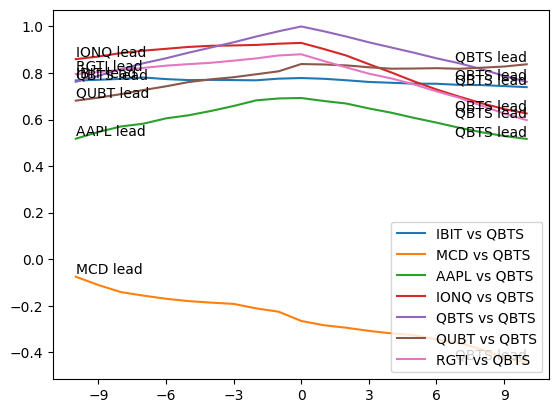

In [14]:
for s in SYMBOLS:
    plot_corrs(s, 'QBTS', 'Close', period=TRADE_DAYS_PER_YEAR//2)

Observation
1. MCD does not correlate to QBTS.
2. Other quantum stocks have high correlation to QBTS near their lead end while correlation drop slightly faster on QBTS lead end.

Look at the correlation of up and down trend using last 6 months data.

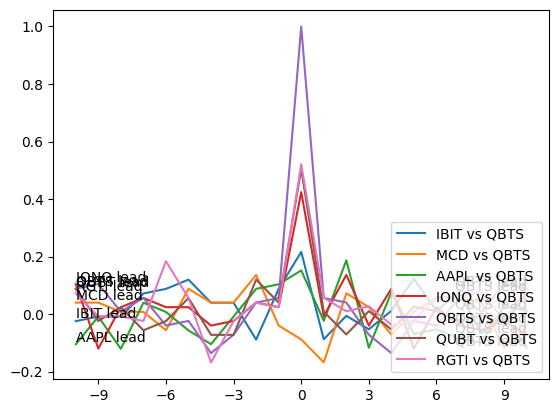

In [15]:
for s in SYMBOLS:
    plot_corrs(s, 'QBTS', 'Close_Raise', period=TRADE_DAYS_PER_YEAR//2)

Observation
1. QBTS is in sync with other quantum stocks.
2. They do not show correlation after shift the data.

#### Granger Causality Test
Refer to the ChatGPT notes at the end of this article.

In [16]:
def is_lead(ticker1, ticker2, period=TRADE_DAYS_PER_YEAR, printout=True):
    data = pd.concat([dfs[ticker2]['Close'][-period:], dfs[ticker1]['Close'][-period:]], axis=1)
    result = grangercausalitytests(data, maxlag=5, verbose=printout)
    F_test_p = 1
    for i in range(1, 6):
        F_test_p = result[i][0]['ssr_ftest'][1]
        if F_test_p < 0.05:
            break
    if F_test_p < 0.05:
        if printout:
            print(f'p={F_test_p:.4f}, {ticker1} leads {ticker2} by {i} day')
        return True, i
    else:
        if printout:
            print(f'p={F_test_p:.4f}, {ticker1} does not lead {ticker2}')
        return False, 0


Does IONQ lead QBTS according to last year Close Price?

In [17]:
is_lead('IONQ', 'QBTS', period=TRADE_DAYS_PER_YEAR, printout=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7408  , p=0.1883  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7620  , p=0.1844  , df=1
likelihood ratio test: chi2=1.7558  , p=0.1852  , df=1
parameter F test:         F=1.7408  , p=0.1883  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9412  , p=0.1457  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.9620  , p=0.1379  , df=2
likelihood ratio test: chi2=3.9308  , p=0.1401  , df=2
parameter F test:         F=1.9412  , p=0.1457  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3119  , p=0.2711  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.0500  , p=0.2561  , df=3
likelihood ratio test: chi2=4.0173  , p=0.2596  , df=3
parameter F test:         F=1.3119  , p=0.2711  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3387  , p=0.2562  

/Users/thyung/opt/anaconda3/envs/pytorch2_8_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


(False, 0)

Does IONQ lead QBTS according to last 6 months Close Price?

In [18]:
is_lead('IONQ', 'QBTS', period=TRADE_DAYS_PER_YEAR//2, printout=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4878  , p=0.0071  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=7.6734  , p=0.0056  , df=1
likelihood ratio test: chi2=7.4454  , p=0.0064  , df=1
parameter F test:         F=7.4878  , p=0.0071  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4692  , p=0.0344  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=7.2324  , p=0.0269  , df=2
likelihood ratio test: chi2=7.0278  , p=0.0298  , df=2
parameter F test:         F=3.4692  , p=0.0344  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4328  , p=0.0194  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=10.9251 , p=0.0121  , df=3
likelihood ratio test: chi2=10.4633 , p=0.0150  , df=3
parameter F test:         F=3.4328  , p=0.0194  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8064  , p=0.0290  

(True, 1)

Check against other stocks.

In [19]:
for symbol in SYMBOLS:
    if symbol != 'QBTS':
        symbol_lead, days = is_lead(symbol, "QBTS", period=TRADE_DAYS_PER_YEAR//2, printout=False)
        if symbol_lead:
            print(f'{symbol} leads QBTS by {days} days')
        else:
            print(f'{symbol} does not lead QBTS')


IBIT does not lead QBTS
MCD does not lead QBTS
AAPL does not lead QBTS
IONQ leads QBTS by 1 days
QUBT does not lead QBTS
RGTI leads QBTS by 1 days


Check the opposite direction.

In [20]:
for symbol in SYMBOLS:
    if symbol != 'QBTS':
        symbol_lead, days = is_lead("QBTS", symbol, period=TRADE_DAYS_PER_YEAR//2, printout=False)
        if symbol_lead:
            print(f'QBTS leads {symbol} by {days} days')
        else:
            print(f'QBTS does not lead {symbol}')

QBTS does not lead IBIT
QBTS does not lead MCD
QBTS leads AAPL by 3 days
QBTS leads IONQ by 3 days
QBTS leads QUBT by 1 days
QBTS leads RGTI by 3 days


#### Oh, contraction! Some of them both lead and lag others.

#### Plot for reference

In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_prices(df_array, name_array, title='Financial Chart', height=PLOT_HEIGHT, width=PLOT_WIDTH):
    fig = make_subplots()
    # 1. plot price
    for i, df in enumerate(df_array):
        if i == 1:
            line_color_inc = 'blue'
            line_color_dec = 'black'
        else:
            line_color_inc = 'green'
            line_color_dec = 'red'
        fig.add_trace(
            go.Ohlc(
                x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name=name_array[i],
                increasing_line_color=line_color_inc,
                decreasing_line_color=line_color_dec
            )
        )

    fig.update_yaxes(title_text='Price')

    # update layout
    fig.update_layout(height=height, width=width, title=title)

    # hide weekends
    fig.update_xaxes(rangebreaks=[dict(bounds=['sat', 'mon'])])

    fig.update_layout(
        hovermode='x unified',
        hoverlabel=dict(
            bgcolor='rgba(255, 255, 255, 0.5)'
        )
    )

    fig.update_layout(height=600, width=800)

    fig.show()
    return fig

In [22]:
fig = plot_prices([dfs['IONQ'], dfs['QBTS']], ['IONQ', 'QBTS'], title='IONQ, QBTS')

43216 bytes written to file /Users/thyung/working/projects_github/stock_tools/ionq_qbts.png


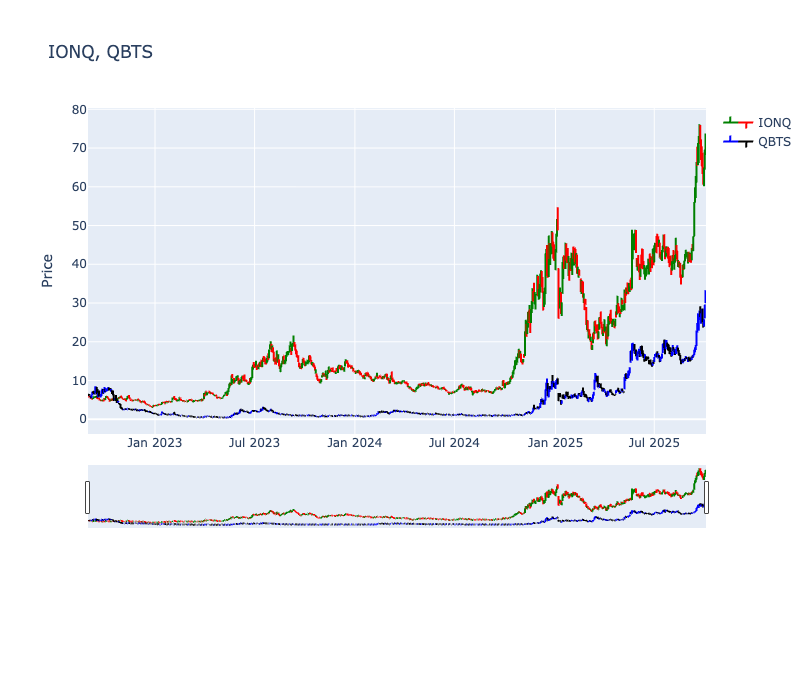

In [23]:

fig.write_html('ionq_qbts.html')
hti = Html2Image()
hti.screenshot(
    html_file='ionq_qbts.html', 
    save_as='ionq_qbts.png', 
    size=(PLOT_WIDTH, PLOT_HEIGHT + 100)     # add margin 100 or image is cropped
) 
os.remove('ionq_qbts.html')
Image('ionq_qbts.png')

In [24]:
pd.__version__

'2.3.2'

In [25]:
yf.__version__

'0.2.65'

In [26]:
import plotly
plotly.__version__

'6.3.0'

In [27]:
import nbformat
nbformat.__version__

'5.10.4'

#### Reference from ChatGPT

To check if **one time series leads another**, you're essentially looking for a **lead-lag relationship** — i.e., whether changes in one series **predict** or **precede** changes in another.

There are several methods to test this, depending on your goals and data type:

---

## 🔍 1. **Cross-Correlation Function (CCF)** — Simple & Common

This is the go-to method to see if one series **lags or leads** another.

### ✅ Example in Python:

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Assume s1 and s2 are pandas Series with same index (time-aligned)
# Example: s1 = leading series, s2 = lagging series
s1 = df['series1']
s2 = df['series2']

# Normalize (optional but recommended)
s1 = (s1 - s1.mean()) / s1.std()
s2 = (s2 - s2.mean()) / s2.std()

# Compute cross-correlation at different lags
max_lag = 20
correlations = [s1.corr(s2.shift(lag)) for lag in range(-max_lag, max_lag + 1)]

# Plot
lags = range(-max_lag, max_lag + 1)
plt.figure(figsize=(10, 5))
plt.stem(lags, correlations, use_line_collection=True)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-correlation between series1 and series2')
plt.xlabel('Lag (positive → series1 leads)')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()
```

### 🔁 Interpretation:

* **Positive lag**: `series1` leads `series2` — changes in `series1` come **before** similar changes in `series2`.
* **Negative lag**: `series2` leads `series1`.
* Peak correlation (the max value on the plot) indicates **best lead/lag point**.

---

## 🔍 2. **Granger Causality Test** — Statistical Test

Use this if you want to **test whether one series helps predict the other**.

```python
from statsmodels.tsa.stattools import grangercausalitytests

data = pd.concat([df['series2'], df['series1']], axis=1)  # [target, predictor]
grangercausalitytests(data, maxlag=10)
```

* It tests if `series1` **Granger-causes** `series2`.
* A **low p-value** (typically < 0.05) at a certain lag means predictive causality exists at that lag.

---

## 🔍 3. **Lead-Lag via Rolling Windows**

You can compute rolling correlations at various lags to detect **changing lead-lag dynamics over time**. Useful for financial data or non-stationary signals.

---

## 🧠 Summary: Best method?

| Goal                                | Method                        |
| ----------------------------------- | ----------------------------- |
| Visual inspection of lead/lag       | **Cross-correlation**         |
| Test predictive power (statistical) | **Granger causality**         |
| Explore time-varying relationships  | **Rolling cross-correlation** |

---

Let me know which method you prefer, or if you want to test this with your data — I can help you write a focused snippet.


Great question! Interpreting the **Granger Causality Test** output correctly is key to understanding if one time series helps predict another.

---

## What is Granger Causality?

* **“X Granger-causes Y”** means: past values of **X** contain information that helps predict **Y** beyond what past values of **Y** alone provide.
* It **does not** imply true causation, just predictive ability.

---

## How to interpret the `grangercausalitytests()` output in Python (`statsmodels`)

When you run:

```python
from statsmodels.tsa.stattools import grangercausalitytests

# data is a 2-column DataFrame: [target_series, predictor_series]
grangercausalitytests(data, maxlag=5)
```

You get output for each lag from 1 to `maxlag`. For each lag, multiple test statistics and p-values are printed, such as:

* **ssr_ftest** (F-test on sum of squared residuals)
* **ssr_chi2test** (Chi-squared test on SSR)
* **lrtest** (Likelihood ratio test)
* **params_ftest** (F-test on parameters)

---

### What to look for:

| Step                | Meaning                                                                |
| ------------------- | ---------------------------------------------------------------------- |
| **Null hypothesis** | The predictor time series does **NOT** Granger-cause the target series |
| **Alternative**     | The predictor series Granger-causes the target                         |
| **p-value**         | Probability that the null is true                                      |

---

### How to decide?

* **If p-value < 0.05** (or your significance level), reject the null hypothesis → predictor series *Granger-causes* the target at that lag.
* **If p-value ≥ 0.05**, no significant evidence that predictor helps predict the target.

---

### Example of output snippet:

```
Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.23 , p=0.0436  # <-- p < 0.05 means X Granger causes Y at lag 1
ssr based chi2 test:   chi2=4.35 , p=0.0365
likelihood ratio test: chi2=4.20 , p=0.0405
params F test:           F=4.22 , p=0.0441
```

Here, since all p-values are < 0.05, you conclude that **X Granger-causes Y at lag 1**.

---

### Tips:

* Check results at **multiple lags** — causality may appear only at certain lag lengths.
* Use **domain knowledge** to choose max lag (`maxlag`) — often depends on data frequency and problem context.
* Ensure your data is **stationary** before testing (non-stationary data can invalidate results).

---

If you want, I can help you interpret your actual test output or write a clean summary report for your results!


Great question! Interpreting the **Granger Causality Test** output correctly is key to understanding if one time series helps predict another.

---

## What is Granger Causality?

* **“X Granger-causes Y”** means: past values of **X** contain information that helps predict **Y** beyond what past values of **Y** alone provide.
* It **does not** imply true causation, just predictive ability.

---

## How to interpret the `grangercausalitytests()` output in Python (`statsmodels`)

When you run:

```python
from statsmodels.tsa.stattools import grangercausalitytests

# data is a 2-column DataFrame: [target_series, predictor_series]
grangercausalitytests(data, maxlag=5)
```

You get output for each lag from 1 to `maxlag`. For each lag, multiple test statistics and p-values are printed, such as:

* **ssr_ftest** (F-test on sum of squared residuals)
* **ssr_chi2test** (Chi-squared test on SSR)
* **lrtest** (Likelihood ratio test)
* **params_ftest** (F-test on parameters)

---

### What to look for:

| Step                | Meaning                                                                |
| ------------------- | ---------------------------------------------------------------------- |
| **Null hypothesis** | The predictor time series does **NOT** Granger-cause the target series |
| **Alternative**     | The predictor series Granger-causes the target                         |
| **p-value**         | Probability that the null is true                                      |

---

### How to decide?

* **If p-value < 0.05** (or your significance level), reject the null hypothesis → predictor series *Granger-causes* the target at that lag.
* **If p-value ≥ 0.05**, no significant evidence that predictor helps predict the target.

---

### Example of output snippet:

```
Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.23 , p=0.0436  # <-- p < 0.05 means X Granger causes Y at lag 1
ssr based chi2 test:   chi2=4.35 , p=0.0365
likelihood ratio test: chi2=4.20 , p=0.0405
params F test:           F=4.22 , p=0.0441
```

Here, since all p-values are < 0.05, you conclude that **X Granger-causes Y at lag 1**.

---

### Tips:

* Check results at **multiple lags** — causality may appear only at certain lag lengths.
* Use **domain knowledge** to choose max lag (`maxlag`) — often depends on data frequency and problem context.
* Ensure your data is **stationary** before testing (non-stationary data can invalidate results).

---

If you want, I can help you interpret your actual test output or write a clean summary report for your results!
